The game plan:
1. Label transition errors using time-average thresholding
2. See how early we can classify these errors with a neural network

In [1]:
import os 
import time
import sys 
sys.path.append("../training")
import pickle
import copy
from itertools import combinations, permutations
import timeit
import yaml

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

##################### Local imports ################################
from save_data import process_data
from threshold import ThresholdModel

#################### Helper functions #############################
# One-hot-encodes data for neural network
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],4], dtype=np.int32)
    for idx, x in enumerate(data):
        y_encoded[idx,int(x)] = 1
    return y_encoded

################## Global variables ################################
# Not all global variables are defined here, some necessarily defined below
VALIDATION_SPLIT = 0.3
NP_SEED = 0
np.random.seed(NP_SEED)

START_WINDOW = 0
END_WINDOW = 770
DATA_DIR = "../data/data_0_resplit"

TRANSITION_WINDOW_START = 0
TRANSITION_WINDOW_END = 500

INIT_LEARNING_RATE = 1e-2
BATCH_SIZE = 12800
EPOCHS = 150

# Config file: Has all the data about our global variables and stuff we want to save
GLOBAL_CONFIG = {
    "VALIDATION_SPLIT": VALIDATION_SPLIT,
    "NP_SEED": NP_SEED,
    "START_WINDOW": START_WINDOW,
    "END_WINDOW": END_WINDOW,
    "DATA_DIR": DATA_DIR,
    "TRANSITION_WINDOW_START": TRANSITION_WINDOW_START,
    "TRANSITION_WINDOW_END": TRANSITION_WINDOW_END,
    "INIT_LEARNING_RATE": INIT_LEARNING_RATE,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS
}


2024-04-05 17:38:23.468207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 17:38:23.582700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-05 17:38:23.582721: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-05 17:38:24.078506: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Create a directory to which we will save all results

In [2]:
# Create saving directory, save config file to that directory

transition_errors_dir = os.path.join(os.getcwd(), "transition_errors")
os.makedirs(transition_errors_dir, exist_ok=True)
dirs_used = [i for i in os.listdir(transition_errors_dir) if os.path.isdir(os.path.join(transition_errors_dir, i))]
nums_used = [int(i) for i in dirs_used]

if len(dirs_used)==0:
    SAVE_DIR_NUM = 0
else:
    SAVE_DIR_NUM = max(nums_used) + 1
SAVE_DIR = os.path.join(transition_errors_dir, str(SAVE_DIR_NUM))
os.makedirs(SAVE_DIR, exist_ok = False)
print(f"SAVE_DIR: {SAVE_DIR}")


SAVE_DIR: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/4


## 1. Data

In [3]:
# convert raw ADC data into npy files 
if os.path.exists(f"{DATA_DIR}/X_train.npy") == False:
    process_data(
        start_window=START_WINDOW,
        end_window=END_WINDOW, 
        data_dir=DATA_DIR
    )

# load data
X_tv = np.load(os.path.join(DATA_DIR, 'X_train.npy'))
y_tv = np.load(os.path.join(DATA_DIR, 'y_train.npy'))
X_test = np.load(os.path.join(DATA_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(DATA_DIR, 'y_test.npy'))

# Check that it's the correct size
# X_train_val[0] = I, Q timeseries over (END_WINDOW - START_WINDOW) timesteps
assert X_tv.shape[1] == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"
assert X_test.shape[1] == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"

# Shuffle train-val indeces
tv_shuffler = np.random.permutation(range(X_tv.shape[0]))
X_tv = X_tv[tv_shuffler, :]
y_tv = y_tv[tv_shuffler]

# Train-validate split
X_train = X_tv[:int((1-VALIDATION_SPLIT)*X_tv.shape[0]),:]
y_train = y_tv[:int((1-VALIDATION_SPLIT)*y_tv.shape[0])]
X_val = X_tv[int((1-VALIDATION_SPLIT)*X_tv.shape[0]):, :]
y_val = y_tv[int((1-VALIDATION_SPLIT)*X_tv.shape[0]):]

## 2. Label transition errors using time-average thresholding

Interpretation:
- True positives = qubit is actually in |1>
- True negatives = qubit is actually in |0>
- False positives = excitation error
- False negatives = relaxation error

Obviously, some of these false-positives/false-negatives might be state-preparation errors or the threshold model being wrong. 

In [4]:
def label_transition_errors(y_true, y_pred):
    assert(y_true.shape==y_pred.shape)
    
    y_new = np.zeros(y_true.shape)
    idx_true_pos = np.where((y_true==1)&(y_pred==1))[0]
    idx_true_neg = np.where((y_true==0)&(y_pred==0))[0]
    idx_false_pos = np.where((y_true==0)&(y_pred==1))[0]
    idx_false_neg = np.where((y_true==1)&(y_pred==0))[0]

    #y_new[idx_true_neg] = 0
    y_new[idx_true_pos] = 1
    y_new[idx_false_neg] = 2 # relaxation error
    y_new[idx_false_pos] = 3 # excitation error
    return y_new

# Fit threshold model to training data
thresh_mod = ThresholdModel()
thresh_mod.fit(X_train, y_train)

# Relabel training data with transition errors 
y_train_threshpred = thresh_mod.predict(X_train)
y_train_prime = label_transition_errors(y_train, y_train_threshpred)

# Relabel validation data with transition errors
y_val_threshpred = thresh_mod.predict(X_val)
y_val_prime = label_transition_errors(y_val, y_val_threshpred)

# Relabel test data with transition errors
y_test_threshpred = thresh_mod.predict(X_test)
y_test_prime = label_transition_errors(y_test, y_test_threshpred)

# Check class proportions
print(f"sum(y_train_prime==0) = {sum(y_train_prime==0)}")
print(f"sum(y_train_prime==1) = {sum(y_train_prime==1)}")
print(f"sum(y_train_prime==2) = {sum(y_train_prime==2)}")
print(f"sum(y_train_prime==3) = {sum(y_train_prime==3)}")

print(f"\nsum(y_val_prime==0) = {sum(y_val_prime==0)}")
print(f"sum(y_val_prime==1) = {sum(y_val_prime==1)}")
print(f"sum(y_val_prime==2) = {sum(y_val_prime==2)}")
print(f"sum(y_val_prime==3) = {sum(y_val_prime==3)}")

print(f"\nsum(y_test_prime==0) = {sum(y_test_prime==0)}")
print(f"sum(y_test_prime==1) = {sum(y_test_prime==1)}")
print(f"sum(y_test_prime==2) = {sum(y_test_prime==2)}")
print(f"sum(y_test_prime==3) = {sum(y_test_prime==3)}")


sum(y_train_prime==0) = 310818
sum(y_train_prime==1) = 298841
sum(y_train_prime==2) = 19605
sum(y_train_prime==3) = 7036

sum(y_val_prime==0) = 133419
sum(y_val_prime==1) = 127872
sum(y_val_prime==2) = 8353
sum(y_val_prime==3) = 3056

sum(y_test_prime==0) = 49530
sum(y_test_prime==1) = 47241
sum(y_test_prime==2) = 3088
sum(y_test_prime==3) = 1141


## 3. Rebalance training data

Naive implementation: crop them all to the size of the smallest class (in this case, excitation errors with 7036 samples)

In [5]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train_prime.shape: {y_train_prime.shape}")

N_KEEP = sum(y_train_prime==3)
GLOBAL_CONFIG.update({"N_KEEP": int(N_KEEP)})

# Split into 4 classes, keep only n_keep of each class
X_tp_0 = X_train[y_train_prime==0,:][:N_KEEP,:]
y_tp_0 = y_train_prime[y_train_prime==0][:N_KEEP]

X_tp_1 = X_train[y_train_prime==1,:][:N_KEEP,:]
y_tp_1 = y_train_prime[y_train_prime==1][:N_KEEP]

X_tp_2 = X_train[y_train_prime==2,:][:N_KEEP,:]
y_tp_2 = y_train_prime[y_train_prime==2][:N_KEEP]

X_tp_3 = X_train[y_train_prime==3,:][:N_KEEP,:]
y_tp_3 = y_train_prime[y_train_prime==3][:N_KEEP]

# Recombine
X_train = np.concatenate((X_tp_0, X_tp_1, X_tp_2, X_tp_3), axis=0)
y_train_prime = np.concatenate((y_tp_0, y_tp_1, y_tp_2, y_tp_3), axis=0)

# Shuffle
train_prime_shuffler = np.random.permutation(range(y_train_prime.shape[0]))
X_train = X_train[train_prime_shuffler,:]
y_train_prime = y_train_prime[train_prime_shuffler]

print(f"\nX_train.shape: {X_train.shape}")
print(f"y_train_prime.shape: {y_train_prime.shape}")


X_train.shape: (636300, 1540)
y_train_prime.shape: (636300,)

X_train.shape: (28144, 1540)
y_train_prime.shape: (28144,)


## 4. Crop X data to transition-window

The transitions have usually finished happening before clock-cycle #300 (see "Neural network vs. thresholding, K-fold cross-validation.ipynb", section #7).

In [6]:
def crop(X, start, end):
    # Split into I and Q
    idx_I = np.array([i for i in range(X.shape[1]) if i%2==0])
    idx_Q = np.array([i for i in range(X.shape[1]) if i%2==1])
    X_I = X[:, idx_I]
    X_Q = X[:, idx_Q]

    # Crop to desired window
    X_I = X_I[:, start:end]
    X_Q = X_Q[:, start:end]

    # Recombine
    X = np.zeros(shape = (X_I.shape[0], X_I.shape[1], 2))
    X[:, :, 0] = X_I
    X[:, :, 1] = X_Q
    X = np.reshape(X, newshape = (X_I.shape[0], 2*X_I.shape[1]))

    # Below is to test logic
    # X_I_extract = X[:, [i for i in range(X.shape[1]) if i%2==0]]
    # print(X_I.shape[0]*X_I.shape[1])
    # print(sum(sum(X_I==X_I_extract)))
    return X

if (TRANSITION_WINDOW_START, TRANSITION_WINDOW_END) != (START_WINDOW, END_WINDOW):
    X_train = crop(X_train, TRANSITION_WINDOW_START, TRANSITION_WINDOW_END)
    X_val = crop(X_val, TRANSITION_WINDOW_START, TRANSITION_WINDOW_END)
    X_test = crop(X_test, TRANSITION_WINDOW_START, TRANSITION_WINDOW_END)

## 5. One-hot encode y data for neural network

In [7]:
y_train_prime_oh = one_hot_encode(y_train_prime)
y_val_prime_oh = one_hot_encode(y_val_prime)
y_tv_prime_oh = np.concatenate((y_train_prime_oh, y_val_prime_oh), axis=0)
y_test_prime_oh = one_hot_encode(y_test_prime)

print(f"y_train_prime_oh.shape: {y_train_prime_oh.shape}")
print(f"y_val_prime_oh.shape: {y_val_prime_oh.shape}")
print(f"y_tv_prime_oh.shape: {y_tv_prime_oh.shape}")

y_train_prime_oh.shape: (28144, 4)
y_val_prime_oh.shape: (272700, 4)
y_tv_prime_oh.shape: (300844, 4)


## 6. Train Neural network

Construct it

In [8]:
# Optimal hyperparameters per J
CHECKPOINT_FILENAME = os.path.join(SAVE_DIR, "qmodel.h5")
INPUT_SHAPE = (len(X_train[0]),)
GLOBAL_CONFIG.update({"CHECKPOINT_FILENAME": CHECKPOINT_FILENAME, "INPUT_SHAPE": INPUT_SHAPE})

model = Sequential()
model.add(QDense(4, input_shape=INPUT_SHAPE, name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
model.add(BatchNormalization())

# adding pruning 
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=200, end_step=1000)}
model = prune.prune_low_magnitude(model, **pruning_params)

MODEL_SUMMARY_F = os.path.join(SAVE_DIR, "model_summary.txt")
def myprint(s):
    with open(MODEL_SUMMARY_F,'a') as f:
        print(s, file=f)

model.summary(print_fn = myprint)
GLOBAL_CONFIG.update({"MODEL_SUMMARY_F": MODEL_SUMMARY_F})

2024-04-05 17:39:45.914251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-05 17:39:45.914319: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-05 17:39:45.914377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator3.fnal.gov): /proc/driver/nvidia/version does not exist
2024-04-05 17:39:45.914920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Train it

In [9]:
callbacks = [
    ModelCheckpoint(
    CHECKPOINT_FILENAME,
    monitor="val_loss",
    save_best_only=True,  # Note: J's version doesn't comment this out. Here it's necessary because there is no validation set
    save_weights_only=False,
    save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=75, min_delta=1**-6), # Note: J's version doesn't comment this out. Here it's necessary because there is no validation set
    pruning_callbacks.UpdatePruningStep(),
]
    
opt = Adam(learning_rate=INIT_LEARNING_RATE)
model.compile(
    optimizer=opt, 
    # loss=tf.keras.losses.BinaryCrossentropy(),
    loss=CategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

print(f"X_train.shape: {X_train.shape}")
history = model.fit(
    X_train, 
    y_train_prime_oh, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    shuffle=True, 
    callbacks=callbacks,
    verbose = 1
)


X_train.shape: (28144, 1000)
Epoch 1/150
2/2 [==============================] - 2s 306ms/step - loss: 1.5794 - accuracy: 0.2992 - val_loss: 7.6117 - val_accuracy: 0.3241 - lr: 0.0100
Epoch 2/150
2/2 [==============================] - 0s 112ms/step - loss: 1.0705 - accuracy: 0.4528 - val_loss: 4.9985 - val_accuracy: 0.3296 - lr: 0.0100
Epoch 3/150
2/2 [==============================] - 0s 107ms/step - loss: 0.9846 - accuracy: 0.4774 - val_loss: 3.7113 - val_accuracy: 0.3355 - lr: 0.0100
Epoch 4/150
2/2 [==============================] - 0s 109ms/step - loss: 0.9561 - accuracy: 0.5052 - val_loss: 3.1194 - val_accuracy: 0.3354 - lr: 0.0100
Epoch 5/150
2/2 [==============================] - 0s 104ms/step - loss: 0.9400 - accuracy: 0.5246 - val_loss: 2.7288 - val_accuracy: 0.3382 - lr: 0.0100
Epoch 6/150
2/2 [==============================] - 0s 111ms/step - loss: 0.9291 - accuracy: 0.5425 - val_loss: 2.4581 - val_accuracy: 0.3440 - lr: 0.0100
Epoch 7/150
2/2 [==============================

Strip pruning and save

In [10]:
model = strip_pruning(model)
model.save(CHECKPOINT_FILENAME)

history_file = CHECKPOINT_FILENAME.replace(".h5", "-history.pkl")
with open(history_file, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print(f'Saving history to: {history_file}')
print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')

Saving history to: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/4/qmodel-history.pkl
Saved checkpoint to: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/4/qmodel.h5


## 7. Check performance on validation data

In [11]:
y_val_nnpred = model.predict(X_val)

8522/8522 [==============================] - 10s 1ms/step


In [12]:
creport = classification_report(y_val_prime, np.argmax(y_val_nnpred, axis=1), target_names = ["0", "1", "Relaxation error", "Excitation error"])
cmat = confusion_matrix(y_val_prime, np.argmax(y_val_nnpred, axis=1))

print(f"Classification report:")
print(creport)
np.save(os.path.join(SAVE_DIR, "classification_report_validation_set.npy"), creport)

print("\n\nConfusion matrix:")
print(cmat)
np.save(os.path.join(SAVE_DIR, "confusion_matrix_validation_set.npy"), cmat)

Classification report:
                  precision    recall  f1-score   support

               0       0.95      0.66      0.78    133419
               1       0.98      0.33      0.50    127872
Relaxation error       0.08      0.47      0.13      8353
Excitation error       0.02      0.55      0.04      3056

        accuracy                           0.50    272700
       macro avg       0.51      0.50      0.36    272700
    weighted avg       0.92      0.50      0.62    272700



Confusion matrix:
[[88403   124 42242  2650]
 [  980 42501  3036 81355]
 [ 3770   126  3904   553]
 [  340   735   314  1667]]


## 8. Visualization

In [13]:
def split_and_time_average(X):
    # X: [N_SAMPLES, TIMESERIES_LENGTH]

    # Split into I, Q
    I_idx = [i for i in range(X.shape[1]) if i%2==0]
    Q_idx = [i for i in range(X.shape[1]) if i%2==1]
    
    X_I = X[:, I_idx]
    X_Q = X[:, Q_idx]

    # Average over time-axis
    X_I_mean = np.mean(X_I, axis=1)
    X_Q_mean = np.mean(X_Q, axis=1)
    
    return X_I_mean, X_Q_mean

def split_and_sample_average(X):
    # X: [N_SAMPLES, TIMESERIES_LENGTH]

    # Split into I, Q
    I_idx = [i for i in range(X.shape[1]) if i%2==0]
    Q_idx = [i for i in range(X.shape[1]) if i%2==1]
    
    X_I = X[:, I_idx]
    X_Q = X[:, Q_idx]

    # Average over sample-axis
    X_I_mean = np.mean(X_I, axis=0)
    X_Q_mean = np.mean(X_Q, axis=0)
    
    return X_I_mean, X_Q_mean

In [14]:
def plot_pred(X, y, y_pred, alpha=0.1):

    X_I, X_Q = split_and_time_average(X)

    ################### Plot ###########################
    fig, (ax_0, ax_1, ax_2, ax_3) = plt.subplots(4, 1, figsize = (8, 28))
    ax_0.scatter(X_I[y==0], X_Q[y==0], label = "Truth labels (per thresholding)", alpha = 0.02)
    ax_0.scatter(X_I[y_pred==0], X_Q[y_pred==0], label = "Model predictions", alpha = 0.02)
    ax_0.set_xlabel("I")
    ax_0.set_ylabel("Q")
    ax_0.set_title("|0> states")
    ax_0.legend(bbox_to_anchor = [1,1])
    ax_0.set_xlim([-700, 1000])
    ax_0.set_ylim([-1100, 500])
    ax_0.legend(bbox_to_anchor=[1,1])

    ax_1.scatter(X_I[y==1], X_Q[y==1], label = "Truth labels (per thresholding)", alpha = 0.02)
    ax_1.scatter(X_I[y_pred==1], X_Q[y_pred==1], label = "Model predictions", alpha = 0.02)
    ax_1.set_xlabel("I")
    ax_1.set_ylabel("Q")
    ax_1.set_title("|1> states")
    ax_1.legend(bbox_to_anchor = [1,1])
    ax_1.set_xlim([-700, 1000])
    ax_1.set_ylim([-1100, 500])
    ax_1.legend(bbox_to_anchor=[1,1])

    ax_2.scatter(X_I[y==2], X_Q[y==2], label = "Truth labels (per thresholding)", alpha = 0.02)
    ax_2.scatter(X_I[y_pred==2], X_Q[y_pred==2], label = "Model predictions", alpha = 0.02)
    ax_2.set_xlabel("I")
    ax_2.set_ylabel("Q")
    ax_2.set_title("Relaxation errors")
    ax_2.legend(bbox_to_anchor = [1,1])
    ax_2.set_xlim([-700, 1000])
    ax_2.set_ylim([-1100, 500])
    ax_2.legend(bbox_to_anchor=[1,1])

    ax_3.scatter(X_I[y==3], X_Q[y==3], label = "Truth labels (per thresholding)", alpha = 0.02)
    ax_3.scatter(X_I[y_pred==3], X_Q[y_pred==3], label = "Model predictions", alpha = 0.02)
    ax_3.set_xlabel("I")
    ax_3.set_ylabel("Q")
    ax_3.set_title("Excitation errors")
    ax_3.legend(bbox_to_anchor = [1,1])
    ax_3.set_xlim([-700, 1000])
    ax_3.set_ylim([-1100, 500])
    ax_3.legend(bbox_to_anchor=[1,1])
    
    return fig, (ax_0, ax_1, ax_2, ax_3)

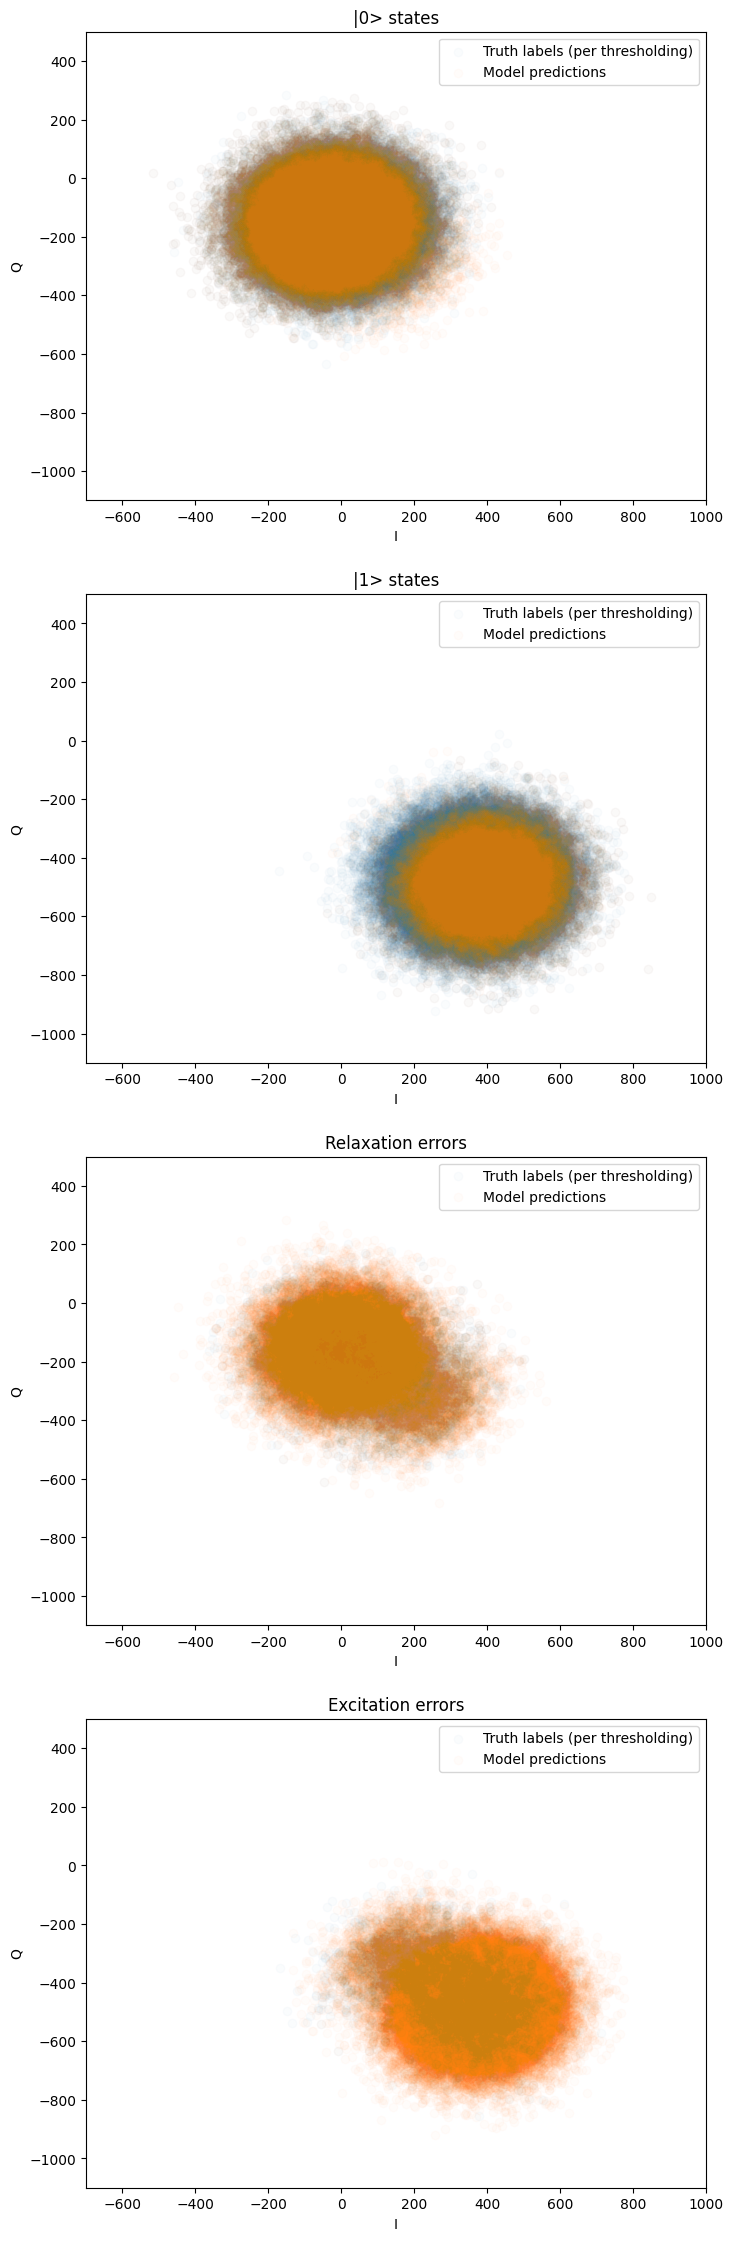

In [15]:
fig, (ax_0, ax_1, ax_2, ax_3) = plot_pred(X_val, y_val_prime, np.argmax(y_val_nnpred, axis=1))
fig.savefig(os.path.join(SAVE_DIR, "predictions_validation_set.png"))
fig.show()

In [16]:
def plot_traces(X, y):

    # True positives
    idx_0 = np.where(y==0)[0]
    X_0 = X[idx_0]
    X_0_I, X_0_Q = split_and_sample_average(X_0)
    

    # False negatives
    idx_1 = np.where(y==1)[0]
    X_1 = X[idx_1]
    X_1_I, X_1_Q = split_and_sample_average(X_1)

    # True negatives
    idx_2 = np.where(y==2)[0]
    X_2 = X[idx_2]
    X_2_I, X_2_Q = split_and_sample_average(X_2)
    
    # False positives
    idx_3 = np.where(y==3)[0]
    X_3 = X[idx_3]
    X_3_I, X_3_Q = split_and_sample_average(X_3)


    ################### Plot ###########################
    fig, (ax_I, ax_Q) = plt.subplots(2,1, figsize = (12, 8))
    ax_I.plot(range(X_0_I.shape[0]), X_0_I, label = "|0> states")
    ax_I.plot(range(X_1_I.shape[0]), X_1_I, label = "|1> states")
    ax_I.plot(range(X_2_I.shape[0]), X_2_I, label = "Relaxation errors")
    ax_I.plot(range(X_3_I.shape[0]), X_3_I, label = "Excitation errors")
    ax_I.set_xlabel("Clock cycle (~3ns)")
    ax_I.set_ylabel("I")
    ax_I.legend(bbox_to_anchor = (1,1))
    
    ax_Q.plot(range(X_0_Q.shape[0]), X_0_Q, label = "|0> states")
    ax_Q.plot(range(X_1_Q.shape[0]), X_1_Q, label = "|1> states")
    ax_Q.plot(range(X_2_Q.shape[0]), X_2_Q, label = "Relaxation errors")
    ax_Q.plot(range(X_3_Q.shape[0]), X_3_Q, label = "Excitation errors")
    ax_Q.set_xlabel("Clock cycle (~3ns)")
    ax_Q.set_ylabel("Q")
    ax_Q.legend(bbox_to_anchor = (1,1))
    
    return fig, (ax_I, ax_Q)

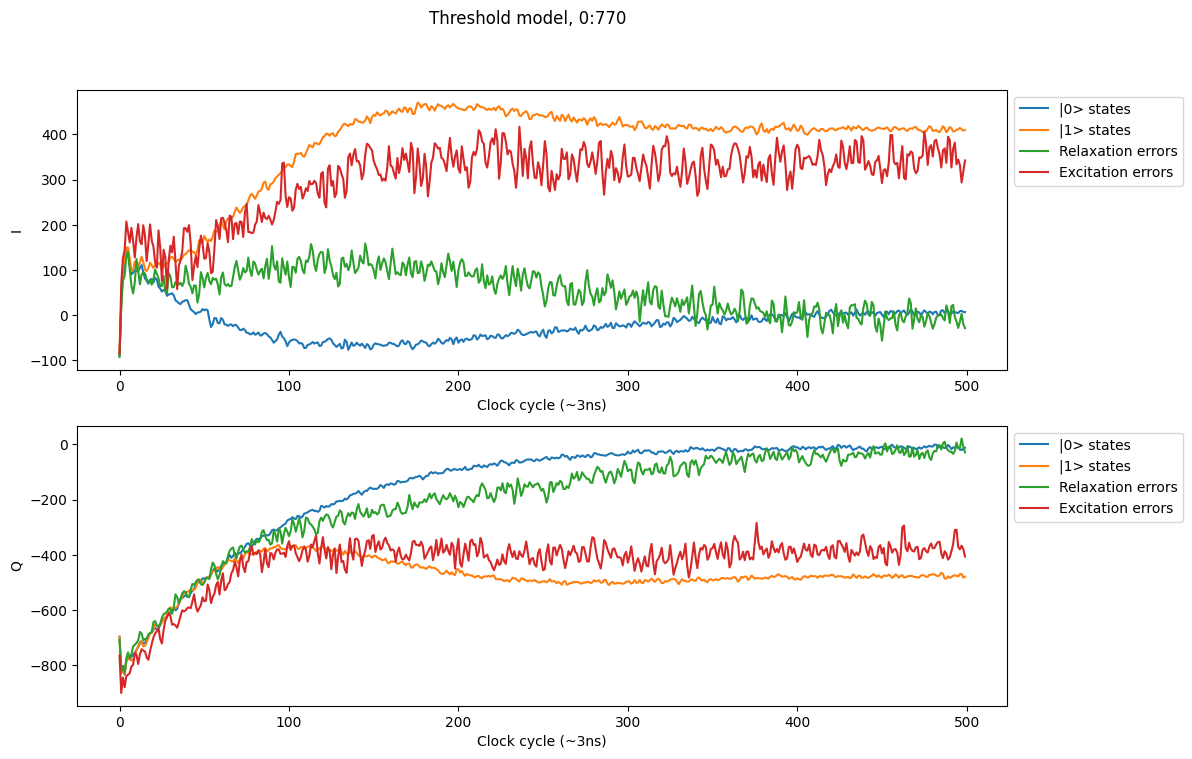

In [17]:
fig_thresh_trace, (ax_I_thresh_trace, ax_Q_thresh_trace) = plot_traces(X_val, y_val_prime)
fig_thresh_trace.suptitle(f"Threshold model, {START_WINDOW}:{END_WINDOW}")
fig.savefig(os.path.join(SAVE_DIR,"thresh_traces.png"))
fig.show()

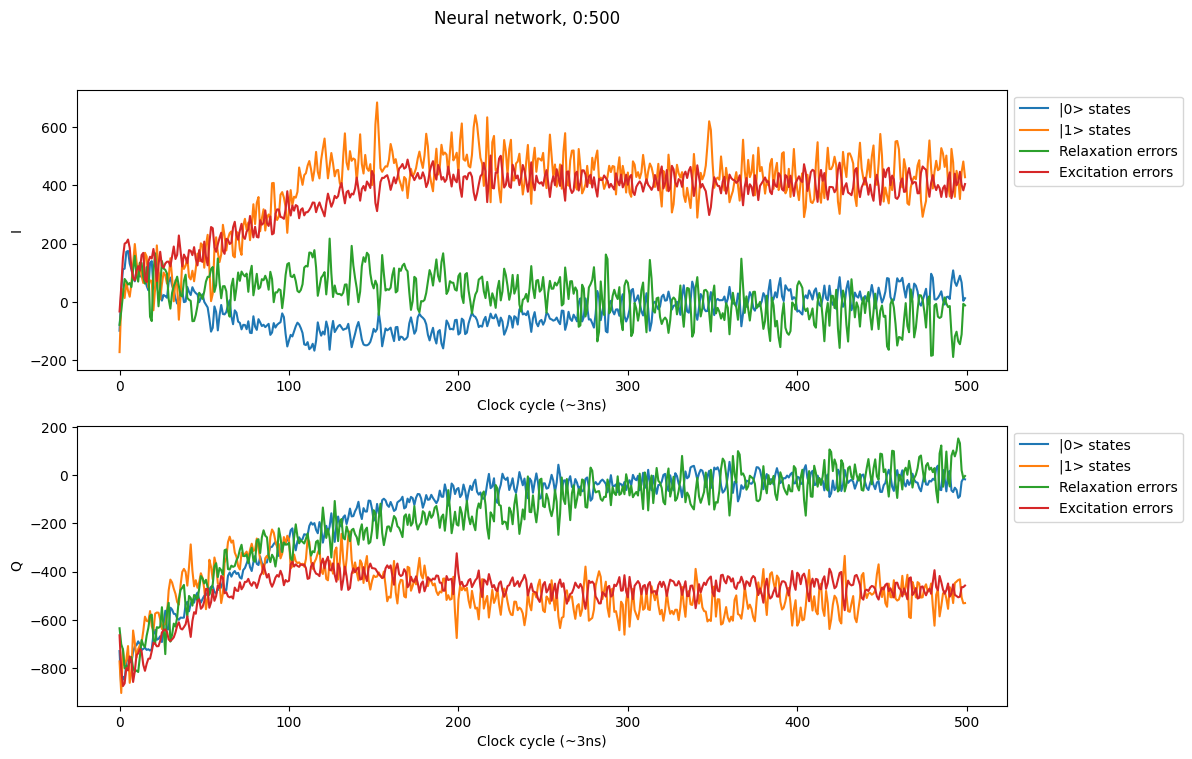

In [18]:
fig_NN_trace, (ax_I_NN_trace, ax_Q_NN_trace) = plot_traces(X_val, np.argmax(y_val_nnpred, axis = 1))
fig_NN_trace.suptitle(f"Neural network, {TRANSITION_WINDOW_START}:{TRANSITION_WINDOW_END}")
fig.savefig(os.path.join(SAVE_DIR, "NN_traces.png"))
fig.show()

## 9. Save config file

In [19]:
with open(os.path.join(SAVE_DIR, "config.yml"), "w") as f:
    yaml.dump(GLOBAL_CONFIG, f)

In [20]:
for k,v in GLOBAL_CONFIG.items():
    print(f"{k}: {v}")

VALIDATION_SPLIT: 0.3
NP_SEED: 0
START_WINDOW: 0
END_WINDOW: 770
DATA_DIR: ../data/data_0_resplit
TRANSITION_WINDOW_START: 0
TRANSITION_WINDOW_END: 500
INIT_LEARNING_RATE: 0.01
BATCH_SIZE: 12800
EPOCHS: 150
N_KEEP: 7036
CHECKPOINT_FILENAME: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/4/qmodel.h5
INPUT_SHAPE: (1000,)
MODEL_SUMMARY_F: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/4/model_summary.txt
